If I don't prevent OpenMP threading, I end up with a *ton* of system time from multithreaded BLAS that actually lowers performance:

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import arviz as az
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx
import scipy.linalg as sl
import scipy.stats as ss
import starry
from starry import Map, System, Primary, Secondary
import starry_process
from starry_process import StarryProcess
from starry_starry_process import StarryStarryProcess
import theano
import theano.tensor as tt
from theano.tensor.random.utils import RandomStream
from tqdm.notebook import tqdm

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Formulas:
$$
N\left( f \mid M y, C \right) N\left( y \mid \mu, \Lambda \right) = N\left( y \mid a, A \right) N\left( f \mid b, B \right)
$$
where
$$
A^{-1} = \Lambda^{-1} + M^T C^{-1} M
$$
$$
a = A \left( \Lambda^{-1} \mu + M^T C^{-1} f \right)
$$
$$
b = M \mu
$$
$$
B = C + M \Lambda M^T
$$

There is an additional wrinkle: we do not want to impose a prior on the $Y^0_0$
component of the surface map (i.e. the constant term); that is, we want its
prior to be flat.  That is equivalent to setting the corresponding components of
the precision matrix to zero (i.e. $\Lambda_{00} \to \infty$, or infinite
uncertainty about this quantity in the Gaussian prior):
$$
\Lambda^{-1}_{0i} = \Lambda^{-1}_{i0} = 0,
$$

which makes $\Lambda^{-1}$ not, itself, invertible.  Because the flux
measurements still constrain the amplitude of the constant term, however, the
posterior ($A$ and $a$) for the map is well-posed.  In order to implement this,
we will need to have the components of the inverse of $\Lambda^{-1}_{ij}$ for
$i,j > 0$.  

Now we will tackle $B^{-1}$ which is needed for the marginal likelihood.  First,
use S-M-W to write (this expression also appears in the Hogg note)
$$
B^{-1} = \left( C + M \Lambda M^T \right)^{-1} = C^{-1} - C^{-1} M \left( \Lambda^{-1} + M^T C^{-1} M \right)^{-1} M^T C^{-1} = C^{-1} - C^{-1} M A M^T C^{-1}.
$$

In [42]:
starry.config.lazy = True

ydeg = 15
udeg = 2

u1 = 0.4
u2 = 0.26

r = 20.0
dr = 5.0
n = 1
c = 0.5
mu = 30.0
sigma = 5.0

prot_true = 30.0
prot = prot_true
porb_true = 4.887802443
porb = porb_true

stellar_inc_true = 90.0
stellar_inc = stellar_inc_true
stellar_obl_true = -30.0
stellar_obl = stellar_obl_true

rng = np.random.default_rng(302592346730275158208684369480422136411)

pri = Primary(starry.Map(ydeg, udeg=udeg, inc=stellar_inc, obl=stellar_obl),
              r=0.683, m=0.81, prot=prot, t0=0.0)
rp_true = 0.04*pri.r.eval()
b_true = 0.0
sec = Secondary(starry.Map(0, 0), 
                t0=0, r=rp_true, m=1e-3*pri.m.eval(), prot=1.0,
                porb=porb, ecc=0.0, Omega=0, inc=90.0) # FIXME: inc should be computed from b_true
pri.map[1] = u1
pri.map[2] = u2

sys = System(pri, sec)

Ttr_half = 0.1
dt_in_transit = Ttr_half / 20.0
dt_out_transit = prot / 20.0

sp = StarryProcess(n=n, mu=mu, sigma=sigma, r=r, dr=dr, ydeg=ydeg, udeg=udeg, marginalize_over_inclination=False, seed=rng.integers(0, 1<<32))

y_true = sp.sample_ylm().eval()[0,:]
y_true[0] = 1.0

T = 3*prot
t_in = np.arange(-T, T, dt_in_transit)
t_out = np.arange(-T, T, dt_out_transit)

t_in_transit = (t_in % sec.porb.eval() < Ttr_half) | (t_in % sec.porb.eval() > sec.porb.eval()-Ttr_half)
t_out_transit = (t_out % sec.porb.eval() < Ttr_half) | (t_out % sec.porb.eval() > sec.porb.eval()-Ttr_half)

t = np.sort(np.concatenate((
    t_in[t_in_transit],
    t_out[~t_out_transit],
)))
nt = len(t)

flux_true = sys.design_matrix(t).eval()[:, :-1] @ y_true

sigma_flux = 1e-4*np.ones_like(flux_true)

flux_obs = flux_true + sigma_flux*rng.normal(size=nt)

ssp = StarryStarryProcess(sys, sp)

Pre-computing some matrices... Done.
Pre-computing some matrices... Done.


/Users/wfarr/miniconda3/envs/StarryStarryProcess/lib/python3.8/site-packages/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


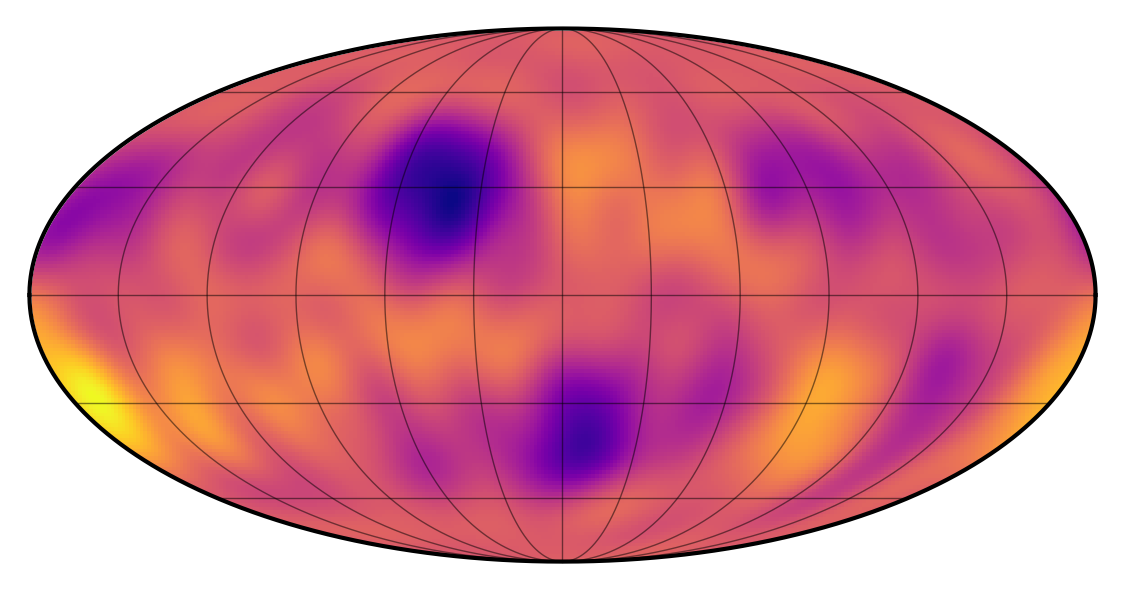

In [22]:
sp.visualize(y_true)

<ErrorbarContainer object of 3 artists>

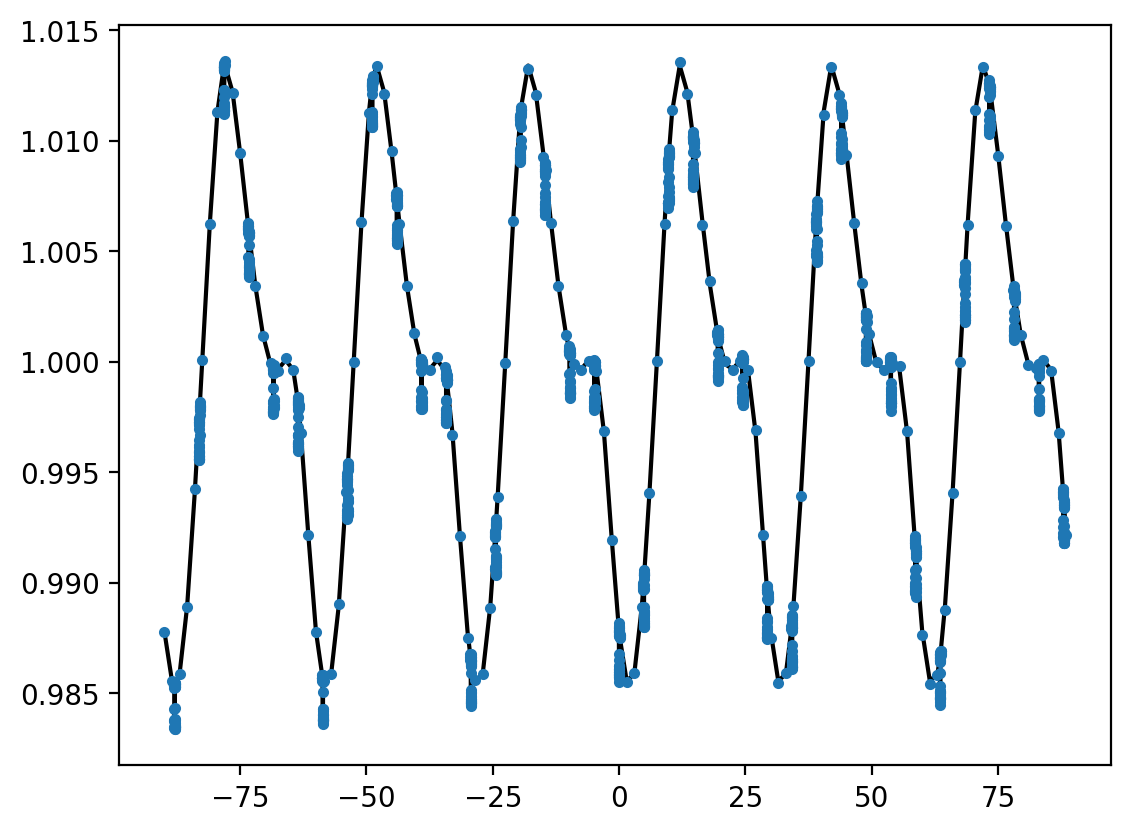

In [23]:
plt.plot(t, flux_true, color='k')
plt.errorbar(t, flux_obs, yerr=sigma_flux, fmt='.')

Here is a plot of the true flux and the observed flux around the first transit:

<ErrorbarContainer object of 3 artists>

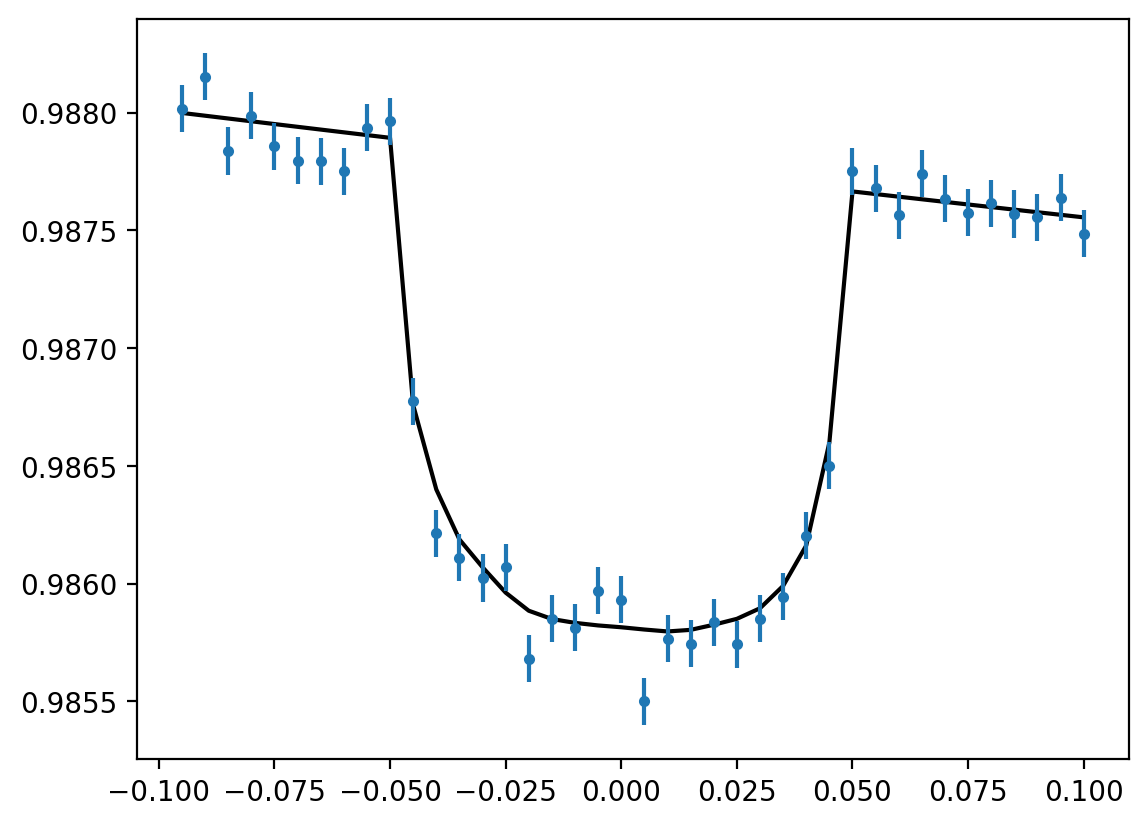

In [24]:
sel = np.abs(t) < sec.porb.eval()/10
plt.plot(t[sel], flux_true[sel], color='k')
plt.errorbar(t[sel], flux_obs[sel], yerr=sigma_flux[sel], fmt='.')

And here is a plot of the posterior median and 1- and 2-$\sigma$ intervals for the flux inferred with fixed non-linear parameters and the observed flux around the first transit:

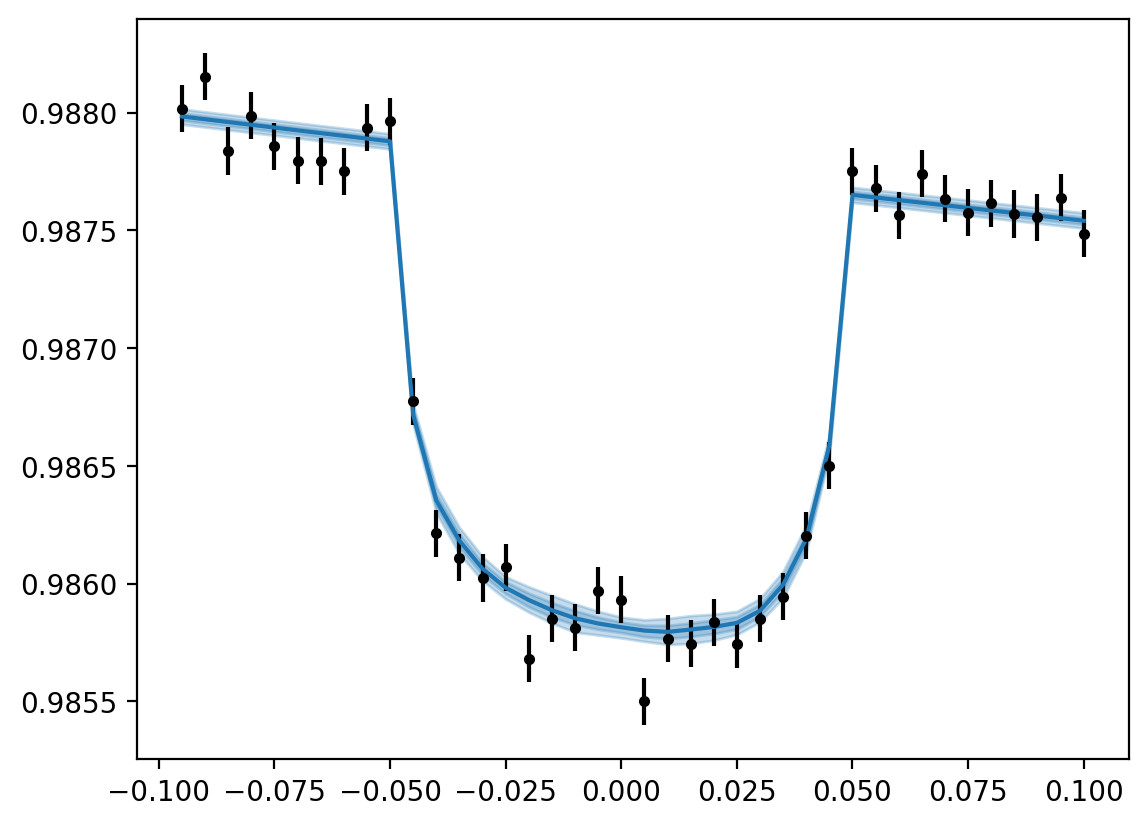

In [25]:
ylm_draw = ssp.sample_ylm_conditional(t, flux_obs, sigma_flux, size=1000).eval()
fluxes = (ssp.design_matrix.eval() @ ylm_draw.T).T
plt.errorbar(t[sel], flux_obs[sel], yerr=sigma_flux[sel], fmt='.', color='k')
l, = plt.plot(t[sel], np.median(fluxes, axis=0)[sel])
plt.fill_between(t[sel], np.quantile(fluxes, 0.84, axis=0)[sel], np.quantile(fluxes, 0.16, axis=0)[sel], color=l.get_color(), alpha=0.25)
plt.fill_between(t[sel], np.quantile(fluxes, 0.975, axis=0)[sel], np.quantile(fluxes, 0.025, axis=0)[sel], color=l.get_color(), alpha=0.25)

And here is the maximum-likelihood flux inferred with fixed non-linear parameters and the observed flux around the first transit:

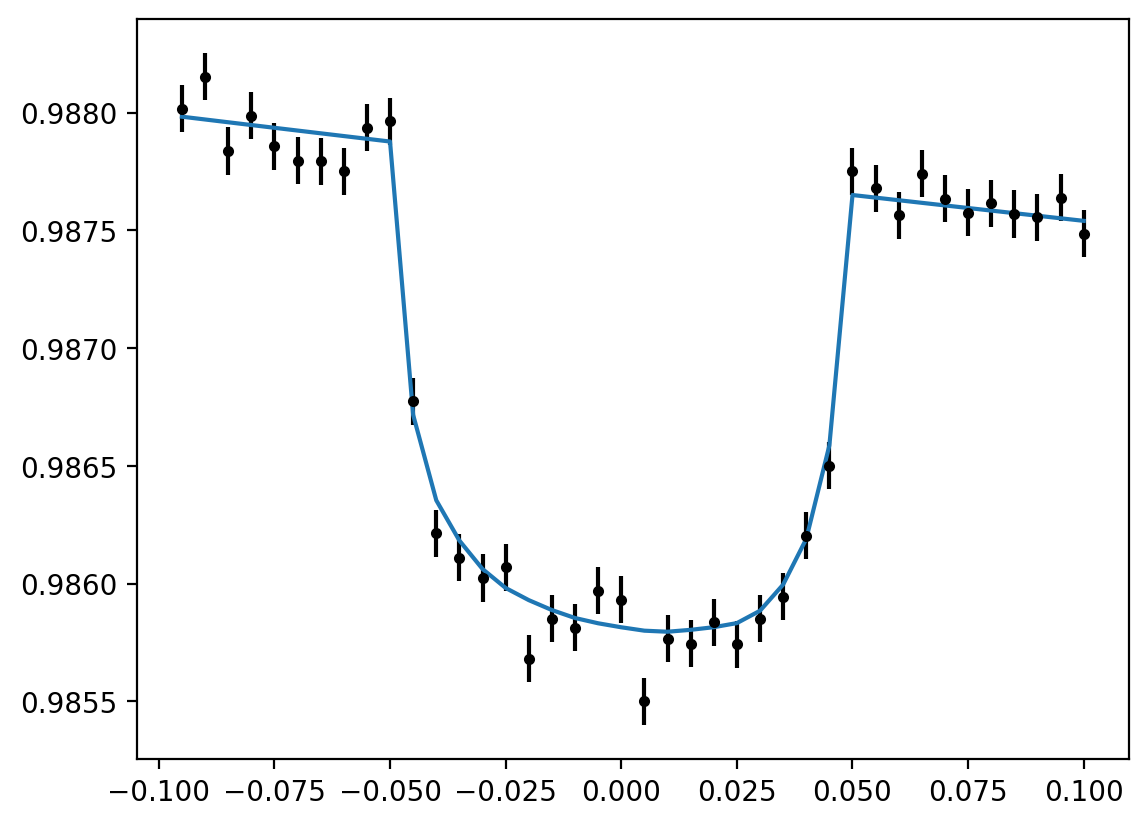

In [26]:
plt.errorbar(t[sel], flux_obs[sel], yerr=sigma_flux[sel], fmt='.', color='k')
plt.plot(t[sel], (ssp.design_matrix.eval() @ ssp.a.eval())[sel])

And here are the true, a random posterior draw, and max-likelihood maps at fixed non-linear parameters:

/Users/wfarr/miniconda3/envs/StarryStarryProcess/lib/python3.8/site-packages/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


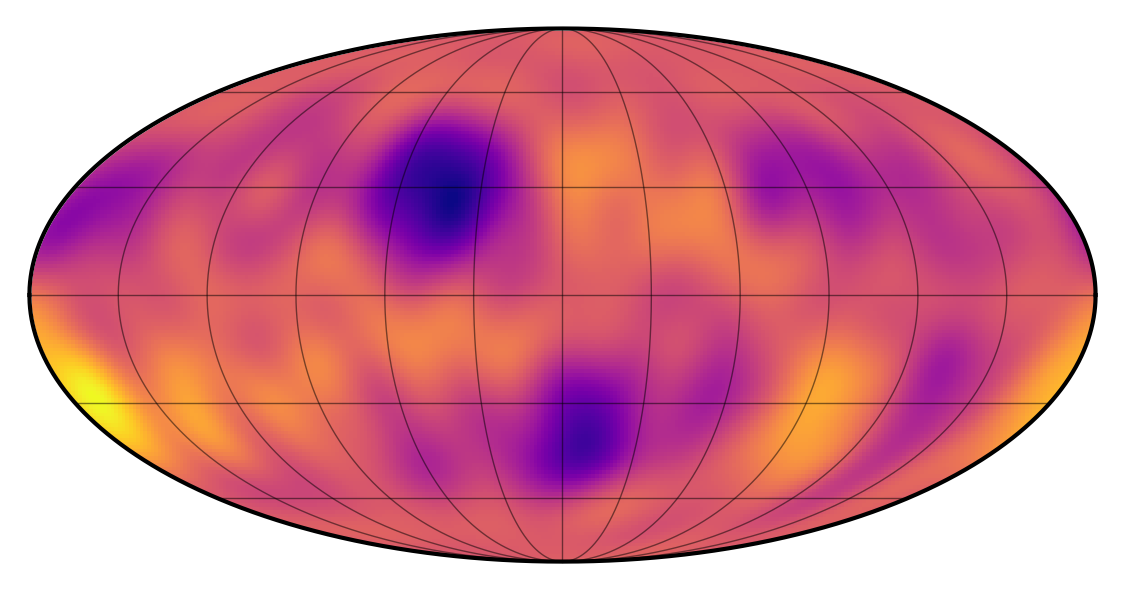

/Users/wfarr/miniconda3/envs/StarryStarryProcess/lib/python3.8/site-packages/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


/Users/wfarr/miniconda3/envs/StarryStarryProcess/lib/python3.8/site-packages/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


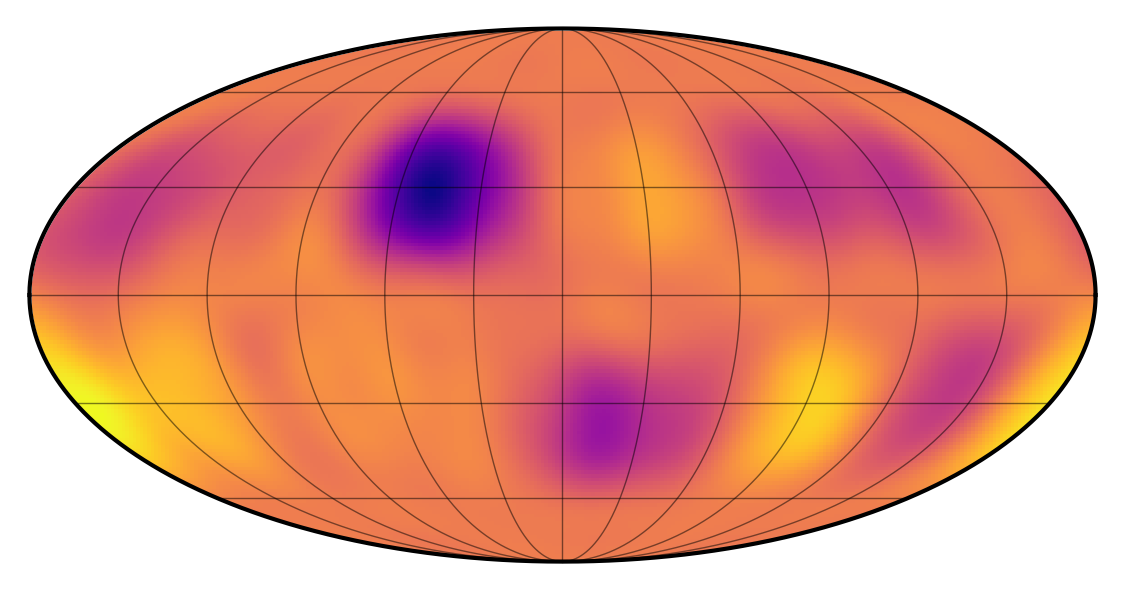

(None, None, None)

In [10]:
sp.visualize(y_true), sp.visualize(ylm_draw), sp.visualize(ssp.a.eval())

Let's double-check the Gaussian factorization; the next two cells should give identical log-likelihoods:

In [27]:
if len(ylm_draw.shape) > 1:
    ylm_draw = ylm_draw[0,:]
resid = flux_obs - ssp.design_matrix.eval() @ ylm_draw
np.sum(ss.norm(loc=0, scale=sigma_flux).logpdf(resid)) - 0.5*np.dot(ylm_draw[1:] - sp.mean_ylm.eval()[1:], np.linalg.solve(sp.cov_ylm.eval()[1:,1:], ylm_draw[1:] - sp.mean_ylm.eval()[1:])) - 0.5*np.linalg.slogdet(sp.cov_ylm.eval()[1:,1:])[1] - 0.5*(len(ylm_draw)-1)*np.log(2*np.pi)

-6267.388515324248

In [28]:
AInv_chol = ssp.AInv_chol.eval()
whitened_ylm_resid = np.dot(AInv_chol.T, ylm_draw - ssp.a.eval())
A_logdet = -2.0*np.sum(np.log(np.diag(AInv_chol)))
ssp.marginal_likelihood(t, flux_obs, sigma_flux).eval() - 0.5*np.dot(whitened_ylm_resid, whitened_ylm_resid) - 0.5*A_logdet - 0.5*len(ylm_draw)*np.log(2*np.pi)

-6267.388518462764

In [29]:
pri.map[:,:] = ylm_draw
sys.show(t[::2]) # , file='/Users/wfarr/Downloads/Hat-P-11b-analog.mp4')

Compiling `compute_rect_grid`... Done.
Compiling `compute_moll_grid`... Done.
Compiling `compute_ortho_grid`... Done.
Compiling `compute_rect_grid`... Done.
Compiling `compute_moll_grid`... Done.
Compiling `compute_ortho_grid`... Done.


Let's try some fitting

In [30]:
Ttotal = t[-1] - t[0]
prot_frac_bounds = min(prot/Ttotal/2, 0.25)
porb_frac_bounds = min(porb/Ttotal/2, 0.25)

t0_bounds = 0.2 # Hard coded!

a = (pri.m.eval()*np.square(sec.porb.eval()/365.25))**(1/3) * 215.03 # Solar radii
bmax = pri.r.eval() / a

with pm.Model() as model:
    log_prot = pm.Uniform('log_prot', np.log(prot) + np.log1p(-prot_frac_bounds), np.log(prot) + np.log1p(prot_frac_bounds))
    prot = pm.Deterministic('prot', tt.exp(log_prot))

    log_porb = pm.Uniform('log_porb', np.log(porb) + np.log1p(-porb_frac_bounds), np.log(porb) + np.log1p(porb_frac_bounds))
    porb = pm.Deterministic('porb', tt.exp(log_porb))

    t0 = pm.Uniform('t0', -t0_bounds, t0_bounds)

    log_rp = pm.Uniform('log_rp', np.log(sec.r.eval()/2), np.log(2*sec.r.eval()))
    rp = pm.Deterministic('rp', tt.exp(log_rp))

    # For some reason, the model errors out if I try to use Omega as a variable
    # on the planetary transit, but it's happy to have a stellar obliquity.
    # Since only the *relative* angle between transit and star is observable
    # anyway, this is the only relevant degree of freedom.  (Visualize: rotate
    # the star-planet system in the sky until the planet's orbit is "horizontal"
    # (zero obliquity).  The lightcurve is still the same.)  So the preferred
    # value of the stellar obliquity will be -Omega from above, and we pass
    # Omega = 0 to the planet below.
    stellar_ori_x = pm.Normal('stellar_ori_x', mu=0, sigma=1, testval=1)
    stellar_ori_y = pm.Normal('stellar_ori_y', mu=0, sigma=1, testval=1)
    stellar_ori_z = pm.Normal('stellar_ori_z', mu=0, sigma=1, testval=1)
    stellar_obl = pm.Deterministic('stellar_obl', 180.0/np.pi*tt.arctan2(stellar_ori_y, stellar_ori_x))
    stellar_inc = pm.Deterministic('stellar_inc', 180.0/np.pi*tt.arccos(stellar_ori_z / tt.sqrt(tt.square(stellar_ori_x) + tt.square(stellar_ori_y) + tt.square(stellar_ori_z))))

    # Impact parameter
    b = pm.Uniform('b', -bmax, bmax)
    planet_inc = pm.Deterministic('planet_inc', 180.0/np.pi*np.arccos(b))

    pri_model = Primary(starry.Map(ydeg=ydeg, udeg=udeg, inc=stellar_inc, obl=stellar_obl), r=float(pri.r.eval()), m=float(pri.m.eval()), prot=prot, t0=0.0)
    pri_model.map[1] = u1
    pri_model.map[2] = u2

    sec_model = Secondary(starry.Map(0,0), 
                          t0=t0, r=rp, m=float(sec.m.eval()), prot=float(sec.prot.eval()),
                          porb=porb, ecc=float(sec.ecc), Omega=0, inc=planet_inc)
    
    sys_model = System(pri_model, sec_model)

    sp_model = StarryProcess(n=n, 
                             mu=tt.as_tensor_variable(mu, 'mu'),
                             sigma=tt.as_tensor_variable(sigma, 'sigma'),
                             r=tt.as_tensor_variable(r, 'r'),
                             dr=tt.as_tensor_variable(dr, 'dr'),
                             ydeg=ydeg, udeg=udeg, 
                             marginalize_over_inclination=False,)

    # Normally we would make another StarryProcess here, but because none of its parameters are being set in the model for now, we can just reuse `sp`
    ssp_model = StarryStarryProcess(sys_model, sp_model)

    pm.Potential('marginal_likelihood', ssp_model.marginal_likelihood(t, flux_obs, sigma_flux))

Pre-computing some matrices... Done.
Pre-computing some matrices... Done.


Let's look at the MAP solution.

In [31]:
with model:
    map_soln = pmx.optimize(maxeval=500)

optimizing logp for variables: [b, stellar_ori_z, stellar_ori_y, stellar_ori_x, log_rp, t0, log_porb, log_prot]


message: Desired error not necessarily achieved due to precision loss.
logp: 4639.380456718918 -> 12375.781506983718


In [43]:
map_soln
true_soln = map_soln.copy()
true_soln.update({
    't0': 0.0,
    'stellar_inc': stellar_inc_true,
    'stellar_obl': stellar_obl_true,
    'rp': rp_true,
    'b': b_true,
    'prot': prot_true,
    'porb': porb_true
})

In [45]:
def marginal_logl(obl, inc):
    obl = obl*np.pi/180.0
    inc = inc*np.pi/180.0
    pt = true_soln.copy()

    z = np.cos(inc)
    x = np.cos(obl)*np.sin(inc)
    y = np.sin(obl)*np.sin(inc)

    pt.update({'stellar_ori_x': x, 'stellar_ori_y': y, 'stellar_ori_z': z})
    return model.logp(pt)

In [46]:
marginal_logl(30,90), marginal_logl(-30, 90)

(array(12374.94223497), array(12371.70432813))

In [39]:
o = np.random.uniform(-180, 180)
i = np.random.uniform(0, 180)
marginal_logl(o,i), marginal_logl(-o, 180-i)

(array(12238.41320668), array(12241.67328474))

In [37]:
start = dict(t0=0.0, stellar_ori_x=np.cos(-30*np.pi/180), stellar_ori_y=np.sin(-30*np.pi/180), stellar_ori_z=0.0, b=0.0, log_prot=np.log(30.0), log_porb=np.log(sec.porb.eval()), log_rp=np.log(sec.r.eval()))
ndraw = 1000
with model:
    trace = pm.sample(ndraw, tune=ndraw, chains=1, init='adapt_full', start=start)

/var/folders/kh/yn7djbsx35vb_gqd5m31brm00000gq/T/ipykernel_47870/1144226144.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(ndraw, tune=ndraw, chains=1, init='adapt_full', start=start)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
Sequential sampling (1 chains in 1 job)
NUTS: [b, stellar_ori_z, stellar_ori_y, stellar_ori_x, log_rp, t0, log_porb, log_prot]


Sampling 1 chain for 111 tune and 0 draw iterations (111 + 0 draws total) took 2805 seconds.


AttributeError: module 'arviz' has no attribute 'from_pymc3'

In [ ]:
az.summary(trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
stellar_ori_x   1.289  0.571   0.285    2.275      0.040    0.029     178.0   
stellar_ori_y  -0.781  0.357  -1.455   -0.243      0.025    0.018     182.0   
stellar_ori_z   0.052  0.061  -0.050    0.183      0.002    0.002     652.0   
log_prot        3.401  0.000   3.401    3.401      0.000    0.000     447.0   
prot           30.000  0.001  29.998   30.003      0.000    0.000     447.0   
log_porb        1.587  0.000   1.587    1.587      0.000    0.000     480.0   
porb            4.888  0.000   4.888    4.888      0.000    0.000     480.0   
t0             -0.000  0.000  -0.000    0.000      0.000    0.000     690.0   
log_rp         -3.599  0.002  -3.603   -3.596      0.000    0.000     592.0   
rp              0.027  0.000   0.027    0.027      0.000    0.000     592.0   
stellar_obl   -31.209  3.729 -38.122  -24.101      0.142    0.100     694.0   
stellar_inc    87.978  1.983  84.654   91.856      0.074    0.052     724.0   
b              -0.000  0.002  -0.004    0.004      0.000    0.000     522.0   
planet_inc     90.027  0.123  89.793   90.212      0.005    0.004     522.0   

               ess_tail  r_hat  
stellar_ori_x     155.0    NaN  
stellar_ori_y     205.0    NaN  
stellar_ori_z     513.0    NaN  
log_prot          358.0    NaN  
prot              358.0    NaN  
log_porb          290.0    NaN  
porb              290.0    NaN  
t0                496.0    NaN  
log_rp            470.0    NaN  
rp                470.0    NaN  
stellar_obl       552.0    NaN  
stellar_inc       448.0    NaN  
b                 472.0    NaN  
planet_inc        472.0    NaN

array([[<Axes: title={'center': 'prot'}>,
        <Axes: title={'center': 'prot'}>],
       [<Axes: title={'center': 'rp'}>, <Axes: title={'center': 'rp'}>],
       [<Axes: title={'center': 't0'}>, <Axes: title={'center': 't0'}>],
       [<Axes: title={'center': 'porb'}>,
        <Axes: title={'center': 'porb'}>],
       [<Axes: title={'center': 'stellar_inc'}>,
        <Axes: title={'center': 'stellar_inc'}>],
       [<Axes: title={'center': 'stellar_obl'}>,
        <Axes: title={'center': 'stellar_obl'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>]],
      dtype=object)

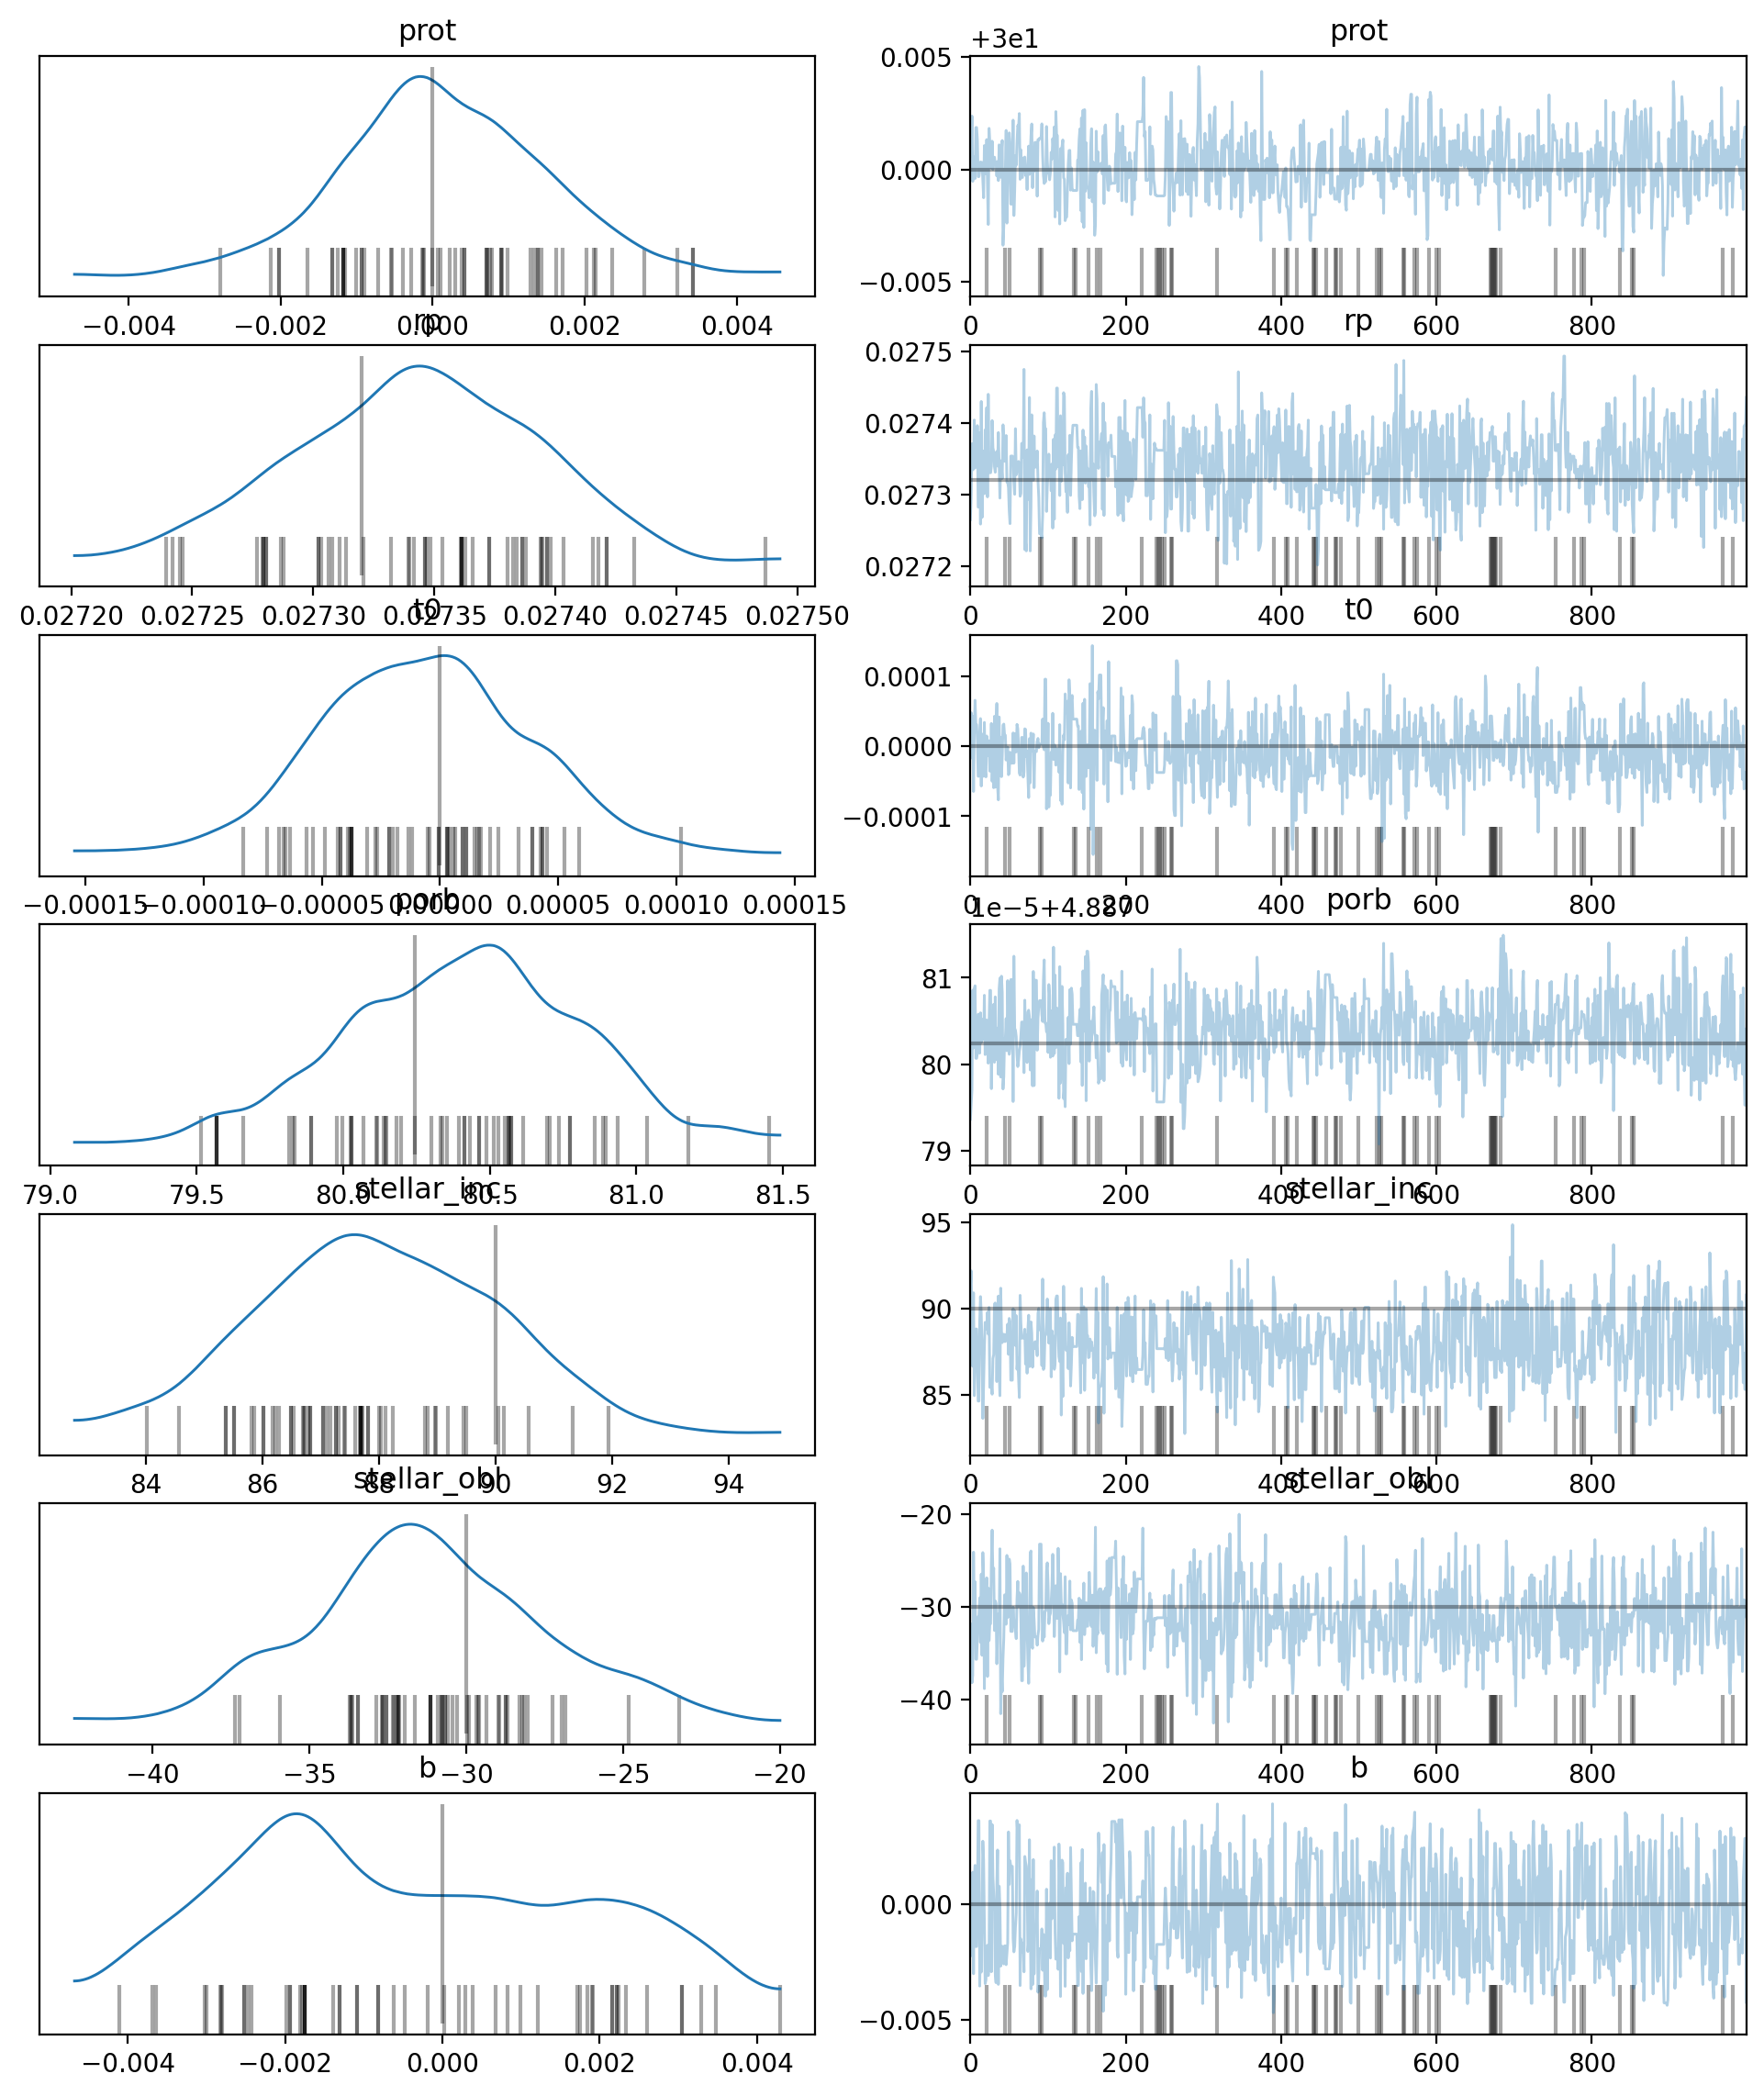

In [ ]:
az.plot_trace(trace, var_names=['prot', 'rp', 't0', 'porb', 'stellar_inc', 'stellar_obl', 'b'],
              lines=[('prot', {}, pri.prot.eval()), 
                     ('rp', {}, sec.r.eval()),
                     ('t0', {}, 0),
                     ('porb', {}, sec.porb.eval()),
                     ('stellar_inc', {}, 90.0), # pri.map.inc.eval()),
                     ('stellar_obl', {}, -30),
                     ('b', {}, 0)])

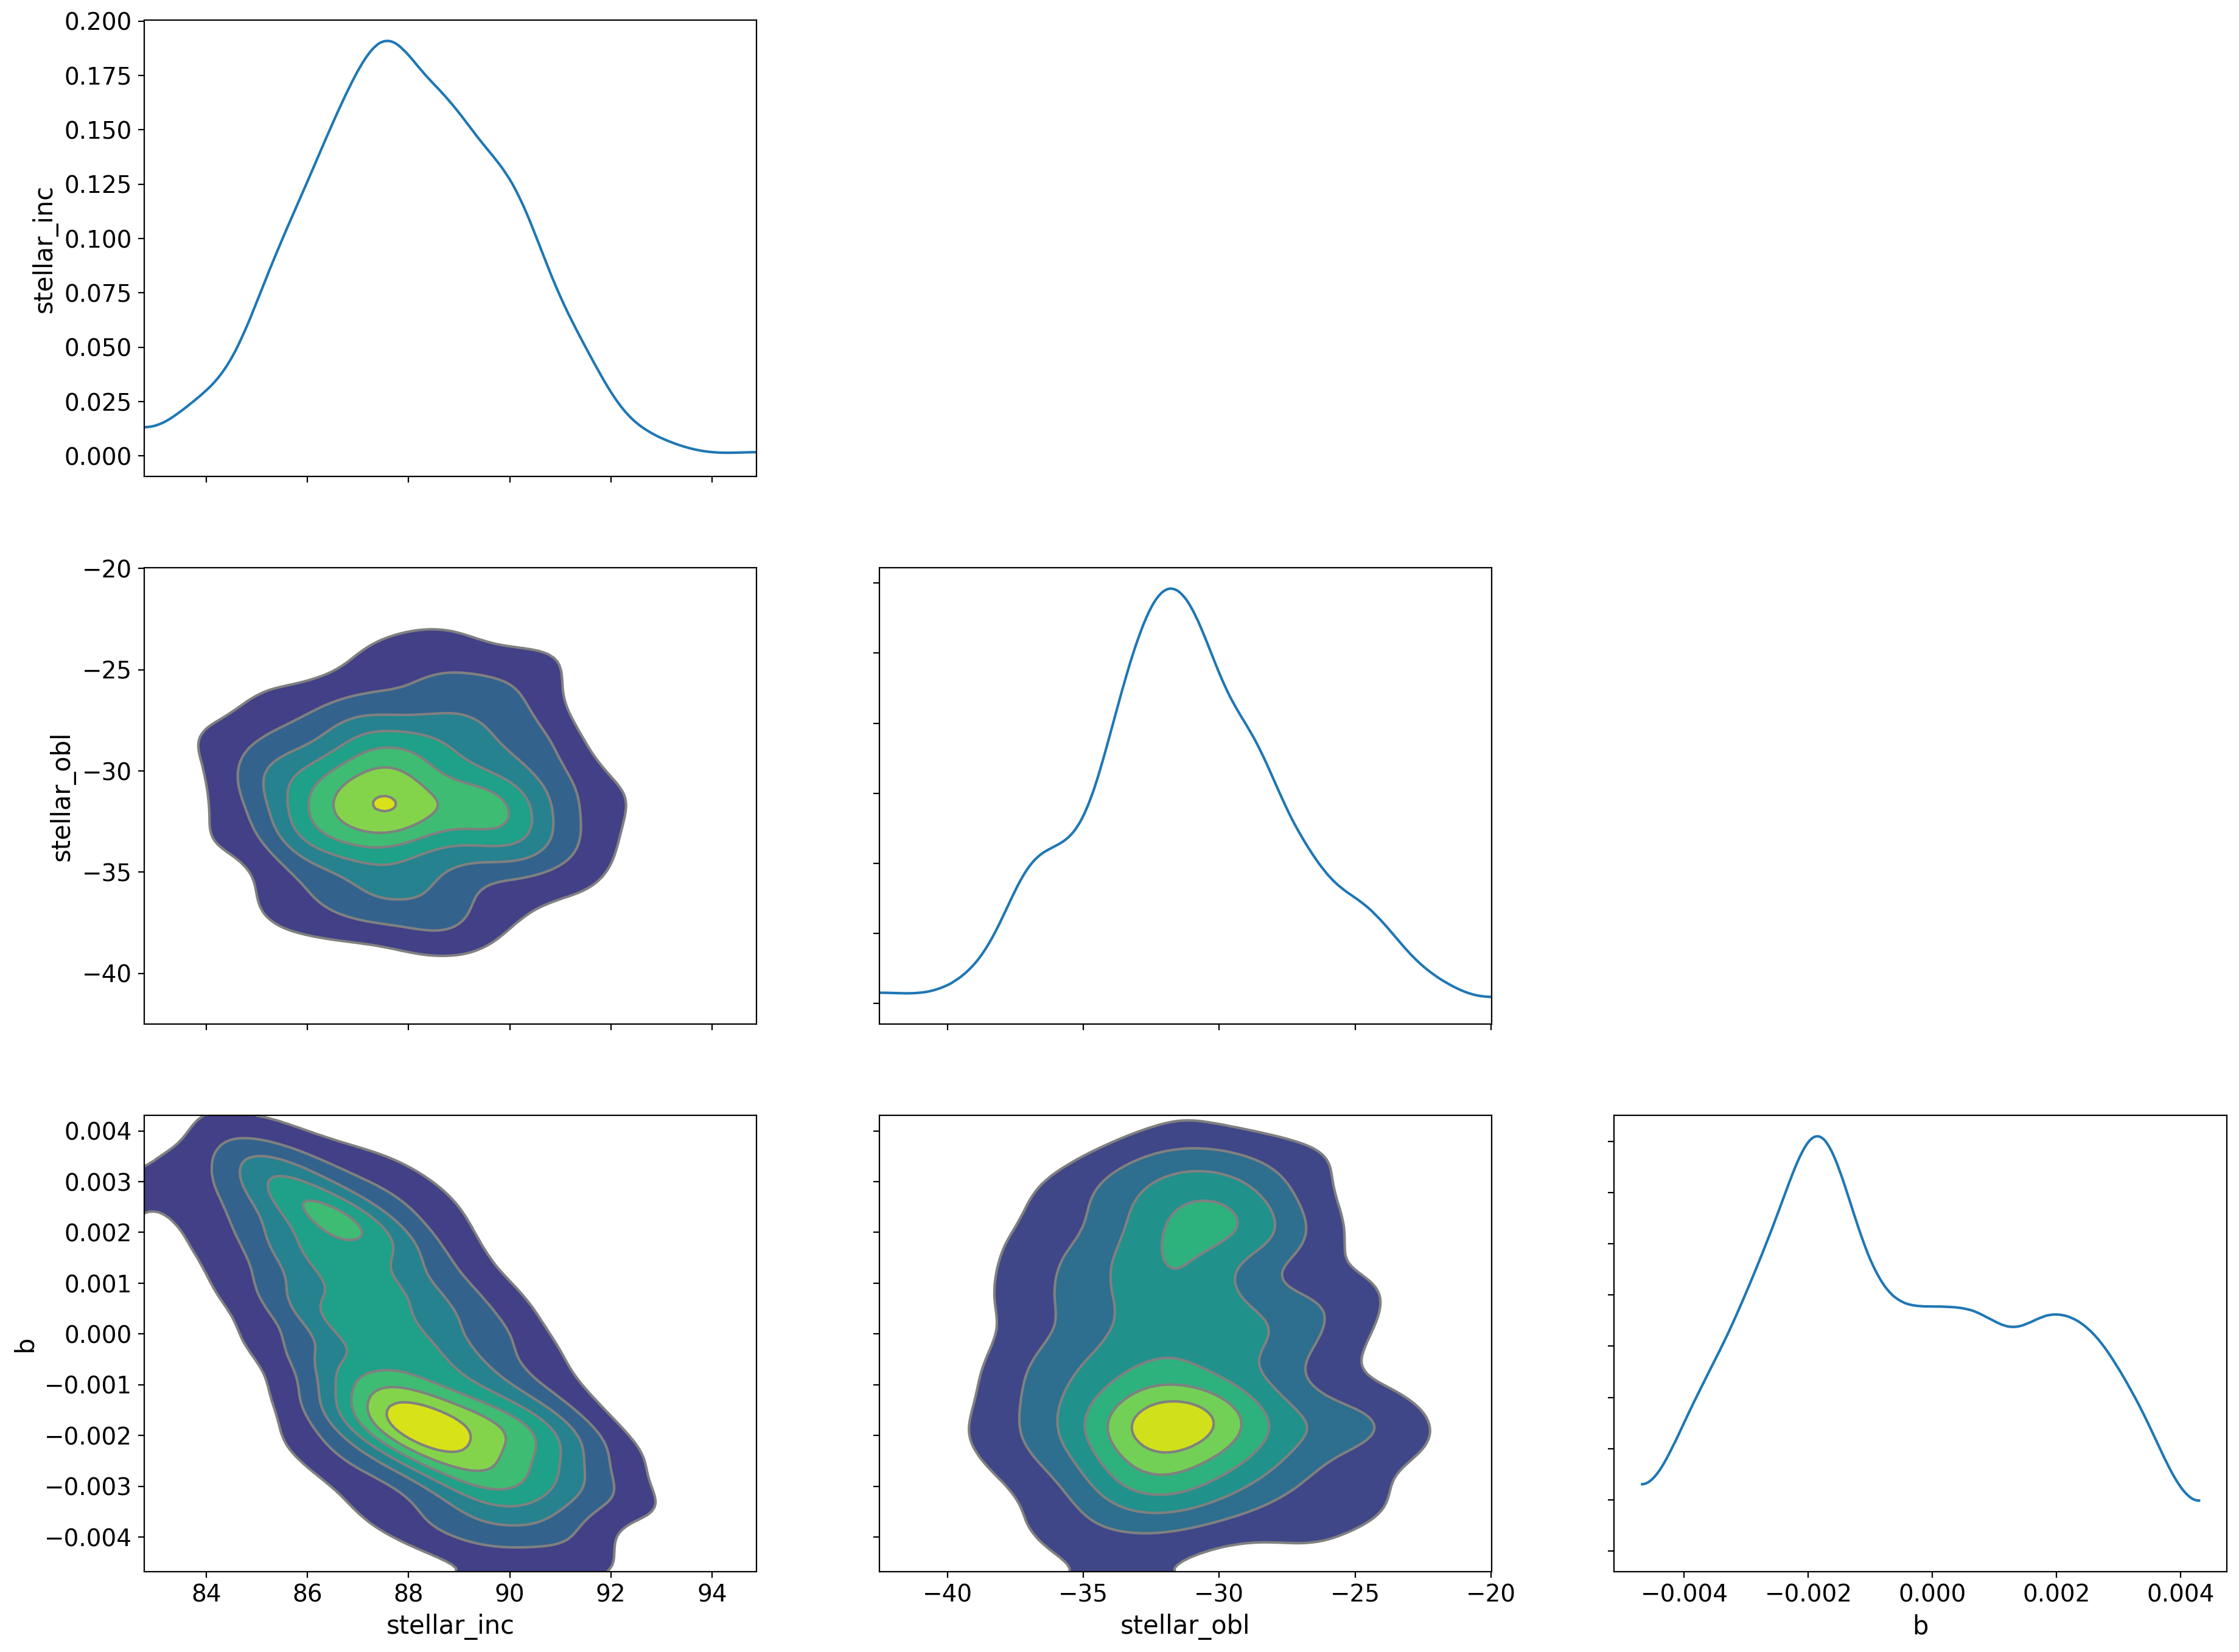

In [ ]:
grid = az.plot_pair(trace, var_names=['stellar_inc', 'stellar_obl', 'b'], kind='kde', marginals=True)

array([[<Axes: >, None],
       [<Axes: xlabel='porb', ylabel='t0'>, <Axes: >]], dtype=object)

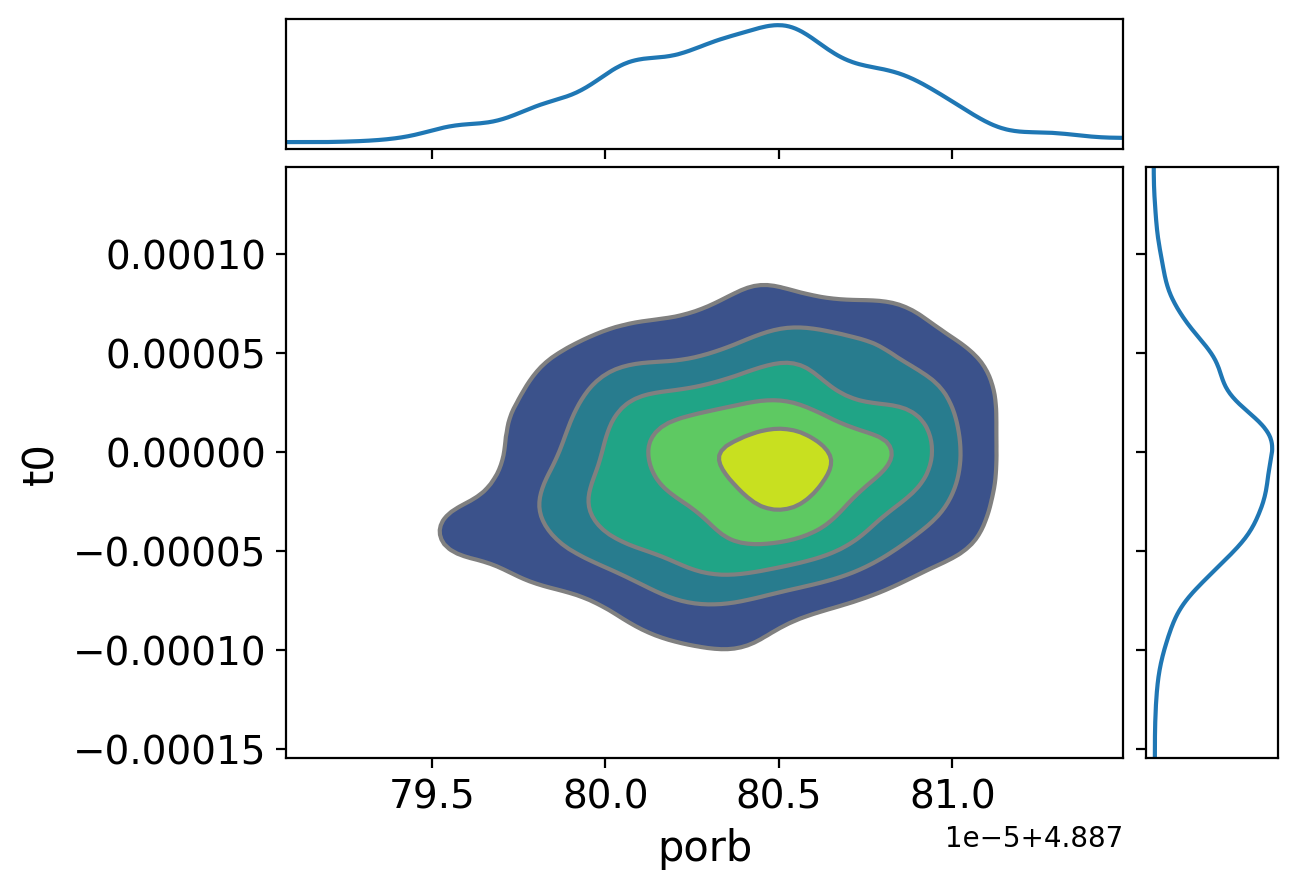

In [ ]:
az.plot_pair(trace, var_names=['porb', 't0'], kind='kde', marginals=True)

Let's fill in all the maps:

In [ ]:
p = trace.posterior.sel(chain=0, draw=0)

In [ ]:
map_ylms = []
f = theano.function([model.prot, model.porb, model.stellar_inc, model.stellar_obl, model.b, model.t0, model.rp], ssp_model.sample_ylm_conditional(t, flux_obs, sigma_flux))

for c in trace.posterior.coords['chain']:
    for d in tqdm(trace.posterior.coords['draw']):
        p = trace.posterior.sel(chain=c, draw=d)
        map_ylms.append(f(p.prot, p.porb, p.stellar_inc, p.stellar_obl, p.b, p.t0, p.rp))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
map_ylms = np.array(map_ylms)
map_ylms = np.reshape(map_ylms, (1, -1, ssp.nlm))

Here is the true surface map

/Users/wfarr/miniconda3/envs/StarryStarryProcess/lib/python3.8/site-packages/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


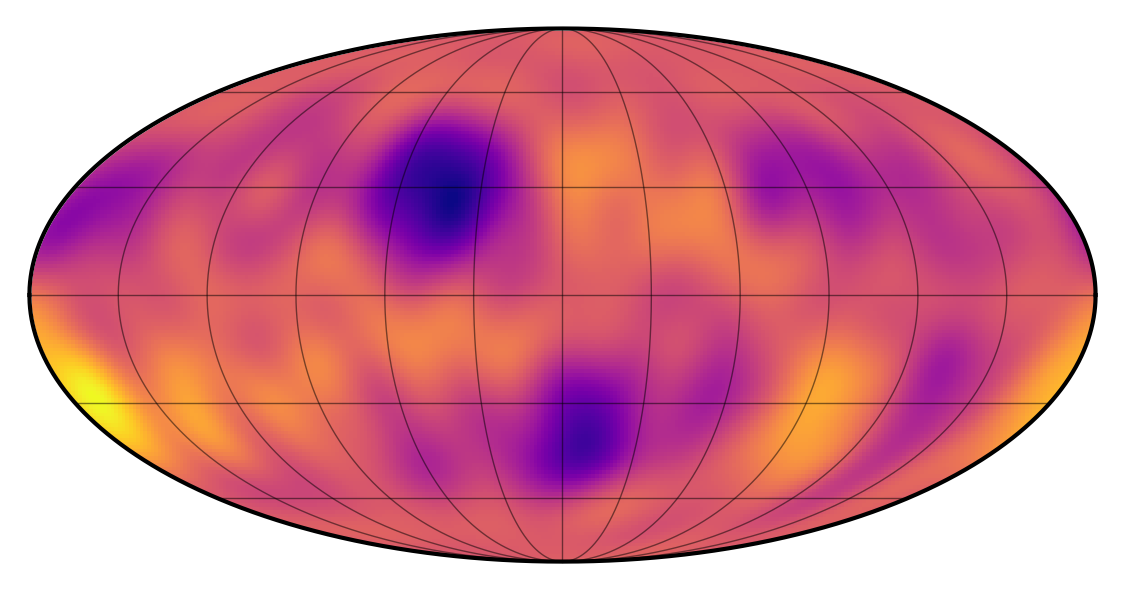

In [ ]:
sp_model.visualize(y_true)

And here is the posterior mean surface map:

/Users/wfarr/miniconda3/envs/StarryStarryProcess/lib/python3.8/site-packages/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


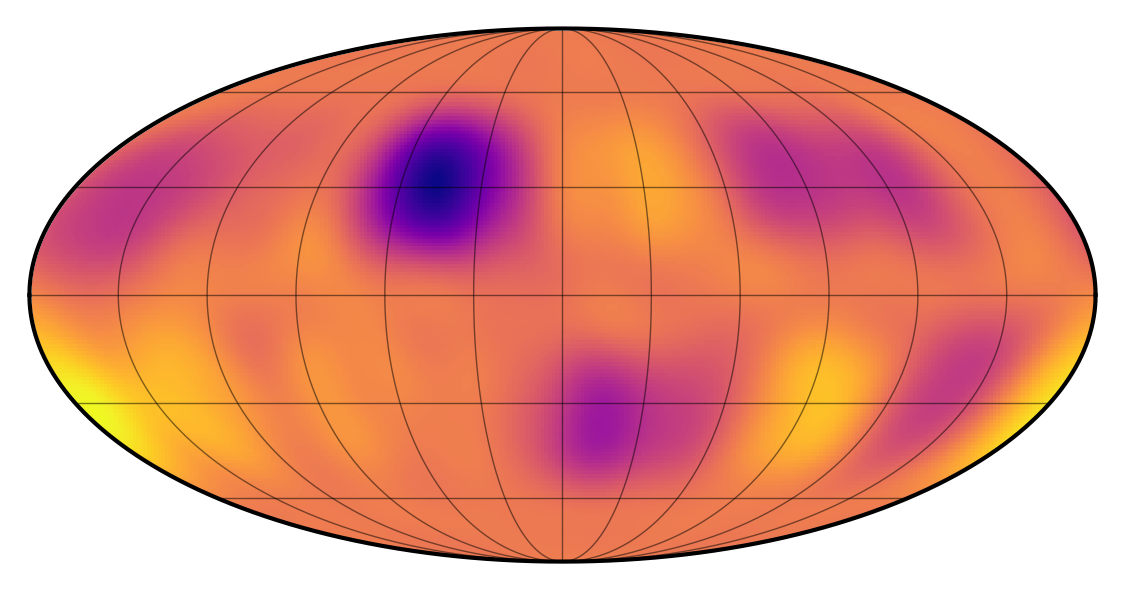

In [ ]:
sp_model.visualize(np.mean(map_ylms, axis=(0,1)))

And some draws from the posterior:

/Users/wfarr/miniconda3/envs/StarryStarryProcess/lib/python3.8/site-packages/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


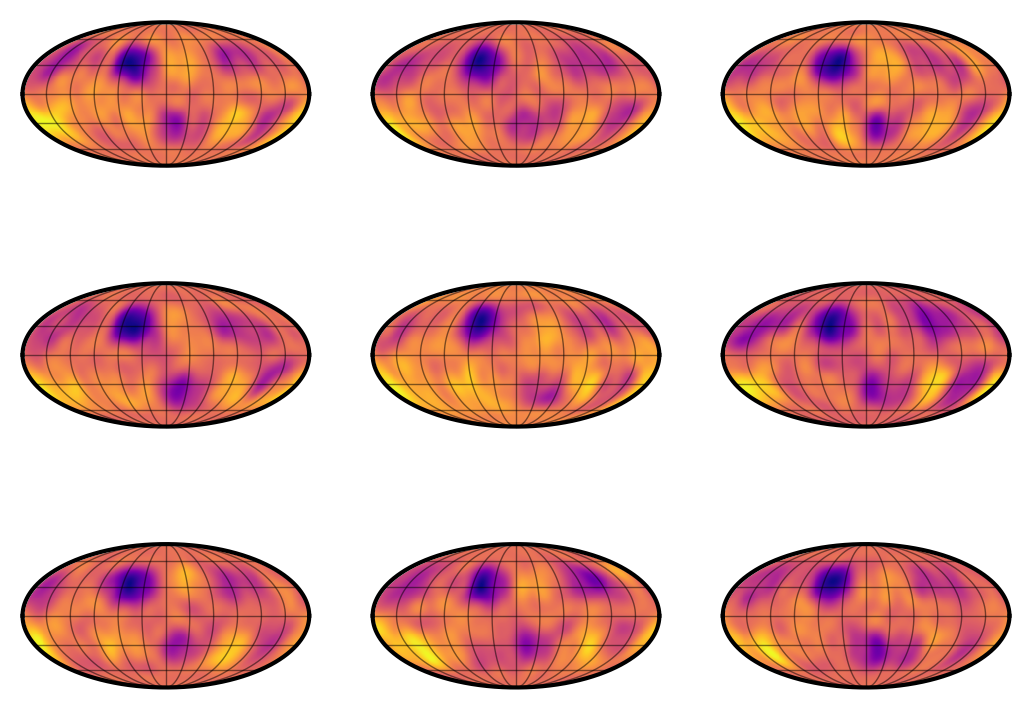

In [ ]:
fig, axs = plt.subplots(3, 3)
for ax in axs.flatten():
    i = np.random.randint(map_ylms.shape[0])
    j = np.random.randint(map_ylms.shape[1])

    y = map_ylms[i,j,:]

    sp_model.visualize(y, ax=ax)


Save the trace:

In [ ]:
az.to_netcdf(trace, '/Users/wfarr/Downloads/SSP-trace.nc')

'/Users/wfarr/Downloads/SSP-trace.nc'